# Coverage of HESSE and MINOS intervals

The MINUIT package provides two ways to compute uncertainty intervals for a fitted parameter, the HESSE method and the MINOS method. Ideally, these intervals should have 68 % coverage probability: if the experiment is repeated with new random data each time, the intervals should cover the true value in 68 % of the cases.

This only asymptotically correct, and if the samples are small, the actual coverage probability can deviate from the expected one. It is often thought that MINOS provides better coverage (closer to the expected value) because its intervals can be asymmetric and seem to retain more information.

As a toy example, I fit the sum of two normal distribution which have equal width but different location parameters. The fitted parameters are the two locations and the shared width. Here is one example fit.

In [1]:
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from numba_stats import norm
import numpy as np
import numba as nb
from matplotlib import pyplot as plt
from IPython.display import display

In [3]:
sigma = 1.0

def gen_data(rng, n):
    n0 = rng.binomial(n, 0.5)
    n1 = n - n0
    return np.append(rng.normal(0, sigma, size=n0), rng.normal(1, sigma, size=n1))

@nb.njit(nogil=True)
def model(x, mu_a, mu_b):
    return 0.5 * (norm.pdf(x, mu_a, sigma) + norm.pdf(x, mu_b, sigma))

rng = np.random.default_rng(0)

data = gen_data(rng, 10000)
m = Minuit(UnbinnedNLL(data, model), mu_a=0, mu_b=1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.065e+04                  │              Nfcn = 31               │
│ EDM = 9.53e-06 (Goal: 0.0002)    │            time = 4.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu_a │  -0.014   │   0.020   │            │            │         │         │       │
│ 1 │ mu_b │   1.013   │   0.020   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬───────────────────┐
│      │     mu_a     mu_b │
├──────┼───────────────────┤
│ mu_a │ 0.000412  -0.2e-3 │
│ mu_b │  -0.2e-3  0.00041 │
└──────┴───────────────────┘

I now run this fit many times on newly drawn random samples. To speed things up, the calculation is done in parallel.

In [5]:
def compute(n):
    n_try = 1000
    rng = np.random.default_rng(n)
    n_hesse = 0
    n_minos = 0
    h_pcov = []
    m_pcov = []
    cor = []
    n_fail = 0
    for i_try in range(n_try):
        for sub in range(5):
            data = gen_data(rng, n)
            nll = UnbinnedNLL(data, model)            
            m = Minuit(nll, mu_a=0, mu_b=1)
            m.migrad()
            m.hesse()
            m.minos()
            if m.valid and m.accurate:
                break
            n_fail += 1
        mu = m.values["mu_a"]
        h_mu = m.errors["mu_a"]
        m_mu = m.merrors["mu_a"]
        cov = m.covariance
        c = cov[1,0] / np.sqrt(cov[0, 0] * cov[1, 1])
        if abs(mu) < h_mu:
            n_hesse += 1
        if (mu + m_mu.lower) < 0 < (mu + m_mu.upper):
            n_minos += 1
        cor.append(c)
    h_pcov.append(n_hesse / n_try)
    m_pcov.append(n_minos / n_try)
    print(f"{n} hesse {h_pcov[-1]:.2f} minos {m_pcov[-1]:.2f} <corr> {np.mean(cor):.3f} {n_fail=}", flush=True)
    return h_pcov, m_pcov, cor

if __name__ == "__main__":
    from concurrent.futures import ThreadPoolExecutor as Pool

    n_pts = (10, 20, 50, 70, 100, 200, 300, 400, 500, 1000, 2000, 3000)

    h_pcov = []
    m_pcov = []
    corr = []
    with Pool() as pool:
        for (h, m, c) in pool.map(compute, n_pts):
            h_pcov.append(h)
            m_pcov.append(m)
            corr.append(c)

10 hesse 0.76 minos 0.75 <corr> -0.388 n_fail=7
20 hesse 0.77 minos 0.73 <corr> -0.450 n_fail=0
50 hesse 0.75 minos 0.67 <corr> -0.458 n_fail=0
100 hesse 0.77 minos 0.69 <corr> -0.461 n_fail=0
70 hesse 0.75 minos 0.67 <corr> -0.472 n_fail=0
200 hesse 0.69 minos 0.66 <corr> -0.435 n_fail=0
1000 hesse 0.67 minos 0.67 <corr> -0.407 n_fail=0
2000 hesse 0.69 minos 0.69 <corr> -0.401 n_fail=0
500 hesse 0.70 minos 0.69 <corr> -0.413 n_fail=0
3000 hesse 0.69 minos 0.69 <corr> -0.404 n_fail=0
400 hesse 0.70 minos 0.69 <corr> -0.422 n_fail=0
300 hesse 0.68 minos 0.67 <corr> -0.420 n_fail=0


I plot the actual coverage probability of the HESSE and MINOS intervals. For small samples, both methods overcover, but the MINOS intervals converge faster to the correct value. So in this case, MINOS did perform better. [This is not always the case, however.](https://scikit-hep.org/iminuit/notebooks/hesse_and_minos.html)

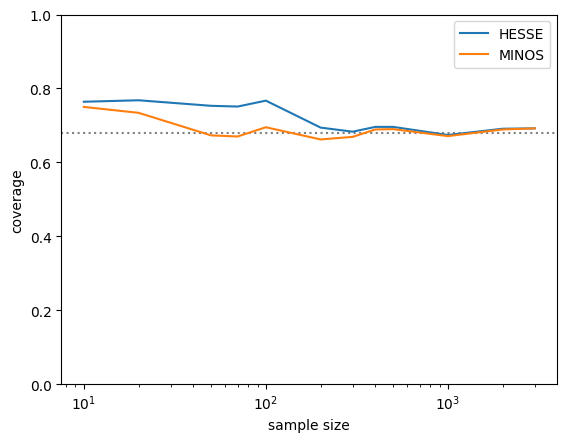

In [6]:
plt.plot(n_pts, h_pcov, label="HESSE")
plt.plot(n_pts, m_pcov, label="MINOS")
plt.axhline(0.68, ls=":", color="0.5", zorder=0)
plt.semilogx()
plt.legend()
plt.ylabel("coverage")
plt.xlabel("sample size")
plt.ylim(0, 1);